<b>Installing dependencies</b>

In [1]:
!pip install mlflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.7/16.7 MB 60.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.5/147.5 KB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 KB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.5/210.5 KB 25.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 575.9/575.9 KB 53.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.3/82.3 KB 11.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 KB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/

In [13]:
import pandas as pd
import sklearn
import pickle
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report,  accuracy_score
from sklearn.model_selection import train_test_split 
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,average_precision_score, precision_recall_curve,auc, plot_precision_recall_curve
from sklearn.model_selection import train_test_split
import keras
from keras.preprocessing import text, sequence
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout
from keras.utils import pad_sequences
import tensorflow as tf

In [3]:
import os
import warnings
import sys

import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet
from urllib.parse import urlparse
import mlflow
import mlflow.sklearn

import logging

logging.basicConfig(level=logging.WARN)
logger = logging.getLogger(__name__)


def eval_metrics(actual, pred):
    precision, recall, thresholds = precision_recall_curve(actual, pred)
    auc_precision_recall = auc(recall, precision)
    return (auc_precision_recall)

In [4]:
#Loading the training, validation and testing data
train=pd.read_csv("train.csv")
val=pd.read_csv("val.csv")
test=pd.read_csv("test.csv")

In [5]:
y_train,X_train=train["label"],train["message"]
y_val,X_val=val["label"],val["message"]
y_test,X_test=val["label"],val["message"]

In [6]:
print("Train size =",len(X_train))
print("Validation size =",len(X_val))
print("Test size =",len(X_test))

Train size = 2786
Validation size = 1114
Test size = 1114


<h3><b>First model : Using a Random Forest Classifier with Tfidf encodings</b></h3>

In [7]:
#Using TfidfVectorizer with 500 features
tfidf=TfidfVectorizer(max_features=500)
encoded_X_train=tfidf.fit_transform(X_train)

In [8]:
encoded_X_val=tfidf.fit_transform(X_val)

In [9]:
encoded_X_test=tfidf.fit_transform(X_test)

In [24]:
#Converting categorical variable into a numerical variable
y_train=y_train.replace("spam",1)
y_train=y_train.replace("ham",0)

In [25]:
y_val=y_val.replace("spam",1)
y_val=y_val.replace("ham",0)

In [26]:
y_test=y_test.replace("spam",1)
y_test=y_test.replace("ham",0)

In [14]:
#Number of estimators
n=500

#Depth
m=6

filename="rfc.pkl"

with mlflow.start_run():
        rfc = RandomForestClassifier(n_estimators=n,max_depth=m, random_state=1)

        rfc.fit(encoded_X_train,y_train)

        pickle.dump(rfc,open(filename,"wb"))

        y_pred=rfc.predict(encoded_X_test)


        res = eval_metrics(y_test, y_pred)

        print("  AUPCR: %s" % res)
        mlflow.log_param("n_estimators", n)
        mlflow.log_param("max_depth", m)
        mlflow.log_metric("aupcr", res)
        tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme

        mlflow.sklearn.log_model(rfc, "model", registered_model_name="RandomForestModel")

  AUPCR: 0.5704667863554758


Successfully registered model 'RandomForestModel'.
2023/02/17 11:44:22 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: RandomForestModel, version 1
Created version '1' of model 'RandomForestModel'.


In [ ]:
mlflow.tracking.MlflowClient().get_model_version("RandomForestModel","1")

<ModelVersion: creation_timestamp=1675756369613, current_stage='None', description=None, last_updated_timestamp=1675756369613, name='RandomForestModel', run_id='98460441478744c0bca2a37e83d9df65', run_link=None, source='file:///content/mlruns/0/98460441478744c0bca2a37e83d9df65/artifacts/model', status='READY', status_message=None, tags={}, user_id=None, version=1>

<h3><b>Second model : Logistic regression with embeddings using a transformer model</b></h3>

In [16]:
!pip install sentence_transformers 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 KB 213.4 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 68.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 58.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 25.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 104.4 MB/s eta 0:00:00
  Created wheel for sentence_transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=6aad8b4d06a47dc4ac8b8425b1b31c2b0d23f237369d1f3d43fa9230c19b36c3
  Stored in directory: /root/.cache/pip/wheels/5e/6f/8c/d88aec621f3f542d26fac0342bef5e693335d125f4e54aeffe
Successfully built sentence_transformers


In [17]:
from sentence_transformers import SentenceTransformer

#Pre-trained model to evaluate the embeddings of the text data
model = SentenceTransformer('all-mpnet-base-v2')


In [27]:
_,X_train=train["label"],train["message"]
_,X_val=val["label"],val["message"]
_,X_test=val["label"],val["message"]

In [28]:
#Encoding the training data
embedded_X_train=model.encode(X_train)

In [29]:
#Encoding the testing data
embedded_X_test=model.encode(X_test)

In [30]:
max_iters=1000

In [31]:
filename="lgr.pkl"

In [32]:
with mlflow.start_run():
        lgr = LogisticRegression(max_iter=max_iters, random_state=1)

        lgr.fit(embedded_X_train,y_train)

        pickle.dump(lgr,open(filename,"wb"))

        y_pred=lgr.predict(embedded_X_test)


        res = eval_metrics(y_test, y_pred)

        print("  AUPCR: %s" % res)
        mlflow.log_param("max_iter", n)
        
        mlflow.log_metric("aupcr", res)
        tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme

        mlflow.sklearn.log_model(lgr, "model", registered_model_name="LogisticRegTransformers")

  AUPCR: 0.9233953504328237


Successfully registered model 'LogisticRegTransformers'.
2023/02/17 11:49:19 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: LogisticRegTransformers, version 1
Created version '1' of model 'LogisticRegTransformers'.


In [ ]:
mlflow.tracking.MlflowClient().get_model_version("RandomForestModel","1")

<ModelVersion: creation_timestamp=1675756369613, current_stage='None', description=None, last_updated_timestamp=1675756369613, name='RandomForestModel', run_id='98460441478744c0bca2a37e83d9df65', run_link=None, source='file:///content/mlruns/0/98460441478744c0bca2a37e83d9df65/artifacts/model', status='READY', status_message=None, tags={}, user_id=None, version=1>

<h3><b>Third model: Building an LSTM based Neural Network with GloVe embeddings </b></h3>

In [33]:
#Downloading GloVe embeddings
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2023-02-17 11:49:50--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-02-17 11:49:51--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-02-17 11:49:51--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [34]:
!unzip glove*.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [35]:
#Using the GloVe embeddings of 100 dimensions
import numpy as np
embeddings_dict = {}
with open("glove.6B.100d.txt", 'r') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[word] = vector

<b>We will use a 1000*100 embedding matrix, with 1000 max features and 100 dimensions.  </b>

In [36]:
all_embs = np.stack(embeddings_dict.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


In [37]:
max_features = 1000
maxlen = 100

In [38]:
#Using TensorFlow tokenizer to tokenize the training data
tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(X_train)
tokenized_train = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(tokenized_train, maxlen=maxlen)

In [39]:
#tokenizing the validation data
tokenized_val = tokenizer.texts_to_sequences(X_val)
X_val = pad_sequences(tokenized_val, maxlen=maxlen)

In [40]:
#Creating the embedding matrix
word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_dict.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

In [41]:
embedding_matrix.shape

(1000, 100)

In [42]:
batch_size = 64
epochs = 10
embed_size = 100

<b>Building the model</b>

In [43]:
model = Sequential()
#Non-trainable embeddidng layer
model.add(Embedding(max_features, output_dim=embed_size, weights=[embedding_matrix], input_length=maxlen, trainable=False))

#First LSTM layer
model.add(LSTM(units=128 , return_sequences = True , recurrent_dropout = 0.25 , dropout = 0.25))

#Second LSTM layer
#Increasing recurrent_dropout and dropout from 0.1 to 0.2 to reduce overfitting
model.add(LSTM(units=64 , recurrent_dropout = 0.2 , dropout = 0.2))

model.add(Dense(units = 32 , activation = 'relu'))

model.add(Dense(1, activation='sigmoid'))

#Using Adam optimizer and Binary Crossentropy as loss function for classification
model.compile(optimizer=keras.optimizers.Adam(lr = 0.01), loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [44]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          100000    
                                                                 
 lstm (LSTM)                 (None, 100, 128)          117248    
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 268,769
Trainable params: 168,769
Non-trainable params: 100,000
_________________________________________________________________


In [45]:
with mlflow.start_run():
  history = model.fit(X_train, y_train, batch_size = batch_size , validation_data = (X_val,y_val) , epochs = epochs)
  

Epoch 1/10
44/44 [==============================] - 45s 881ms/step - loss: 0.1855 - accuracy: 0.9336 - val_loss: 0.1123 - val_accuracy: 0.9587
Epoch 2/10
44/44 [==============================] - 41s 917ms/step - loss: 0.0786 - accuracy: 0.9745 - val_loss: 0.0768 - val_accuracy: 0.9740
Epoch 3/10
44/44 [==============================] - 40s 922ms/step - loss: 0.0578 - accuracy: 0.9856 - val_loss: 0.0964 - val_accuracy: 0.9695
Epoch 4/10
44/44 [==============================] - 40s 910ms/step - loss: 0.0397 - accuracy: 0.9874 - val_loss: 0.0659 - val_accuracy: 0.9820
Epoch 5/10
44/44 [==============================] - 40s 922ms/step - loss: 0.0381 - accuracy: 0.9896 - val_loss: 0.0566 - val_accuracy: 0.9829
Epoch 6/10
44/44 [==============================] - 39s 891ms/step - loss: 0.0272 - accuracy: 0.9928 - val_loss: 0.0701 - val_accuracy: 0.9803
Epoch 7/10
44/44 [==============================] - 38s 858ms/step - loss: 0.0329 - accuracy: 0.9907 - val_loss: 0.0808 - val_accuracy: 0.9731

In [46]:
filename="rnn.pkl"

In [ ]:
pickle.dump(model,open(filename,"wb"))

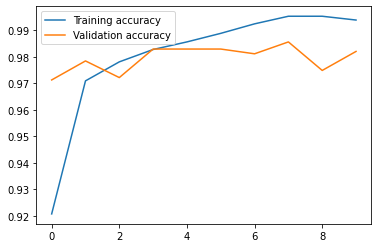

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Training accuracy', 'Validation accuracy'])
plt.show()

In [ ]:
#Tokenizing testing data
tokenized_test = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(tokenized_test, maxlen=maxlen)

In [ ]:
y_pred=model.predict(X_test)

35/35 [==============================] - 2s 55ms/step


In [ ]:
#Binarizing y_pred
for i in range(len(y_pred)): 
  if y_pred[i]<0.5:
    y_pred[i]=0
  else:
    y_pred[i]=1

In [ ]:
res = eval_metrics(y_test, y_pred)
print("  AUPCR: %s" % res)
mlflow.log_param("batch_size",batch_size)
mlflow.log_param("embed_size", embed_size)
mlflow.log_param("epochs", epochs)
mlflow.log_metric("aupcr", res)
tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme
mlflow.sklearn.log_model(model, "model", registered_model_name="RNN")

  AUPCR: 0.9388753526545268


2023/02/07 08:23:54 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpkt2m_gp1/model/model.pkl, flavor: sklearn), fall back to return ['scikit-learn==1.0.2', 'cloudpickle==2.2.1']. Set logging level to DEBUG to see the full traceback.
Successfully registered model 'RNN'.
2023/02/07 08:23:54 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: RNN, version 1
Created version '1' of model 'RNN'.


In [ ]:
 !zip -r mlruns.zip mlruns/ 

  adding: mlruns/ (stored 0%)
  adding: mlruns/.trash/ (stored 0%)
  adding: mlruns/0/ (stored 0%)
  adding: mlruns/0/meta.yaml (deflated 25%)
  adding: mlruns/0/f0119bf868fc47dc8bdbc692ea1e5b9c/ (stored 0%)
  adding: mlruns/0/f0119bf868fc47dc8bdbc692ea1e5b9c/metrics/ (stored 0%)
  adding: mlruns/0/f0119bf868fc47dc8bdbc692ea1e5b9c/metrics/aupcr (stored 0%)
  adding: mlruns/0/f0119bf868fc47dc8bdbc692ea1e5b9c/meta.yaml (deflated 44%)
  adding: mlruns/0/f0119bf868fc47dc8bdbc692ea1e5b9c/artifacts/ (stored 0%)
  adding: mlruns/0/f0119bf868fc47dc8bdbc692ea1e5b9c/artifacts/model/ (stored 0%)
  adding: mlruns/0/f0119bf868fc47dc8bdbc692ea1e5b9c/artifacts/model/requirements.txt (deflated 4%)
  adding: mlruns/0/f0119bf868fc47dc8bdbc692ea1e5b9c/artifacts/model/conda.yaml (deflated 23%)
  adding: mlruns/0/f0119bf868fc47dc8bdbc692ea1e5b9c/artifacts/model/python_env.yaml (deflated 17%)
  adding: mlruns/0/f0119bf868fc47dc8bdbc692ea1e5b9c/artifacts/model/model.pkl (deflated 17%)
  adding: mlruns/0/f011